# Matching challenges

## Using Coarsened Exact Matching to find comparable challenges

In [15]:
%matplotlib inline

import os
import sys

# Include directory for own modules
module_path = os.path.abspath(os.path.join('../../code/own_modules'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from scipy.stats import mannwhitneyu, wilcoxon

from cem import cem
import imp
from concentration_library.concentration_library import gini

# Specify where to find data
DATA_DIR = '../data/'
PLOTS_DIR = '../plots/'


# Set plotting style
sns.set(style="ticks", palette="bright", context='paper', 
        rc={"lines.linewidth": 0.3, 'axes.linewidth':0.1, 
            'xtick.major.size': 2, 'xtick.major.width':0.1, 'xtick.labelsize': 7,
            'ytick.major.size': 2, 'ytick.major.width':0.1, 'ytick.labelsize': 7,
            'legend.fontsize': 7, 'font.size': 7})
mpl.rcParams['font.size'] = 6
mpl.rcParams['axes.titlesize'] = 8
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6
mpl.rcParams['legend.fontsize'] = 6
mpl.rcParams['axes.linewidth'] = 0.25
mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['ytick.major.width'] = 0.25
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['xtick.major.width'] = 0.25
mpl.rcParams['xtick.major.pad']='4'
mpl.rcParams['ytick.major.pad']='4'
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['ytick.minor.width'] = 0.25
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['xtick.minor.width'] = 0.25
#mpl.rcParams['xtick.direction'] = 'out'
#mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['lines.linewidth'] = 0.25
mpl.rcParams['patch.linewidth'] = 0.25
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']

## 1. Define covariates and cutpoints

In [8]:
ch_df = pd.read_csv(f'{DATA_DIR}/challenges_cem.csv')
# OUTLIERS!!! - Get rid of contests with fewer than 10 contestants (5 rounds)
ch_df = ch_df[ch_df['num_contestants']>=10]

ex_q1 = ch_df["average_experience"].quantile(q = 1/3)
ex_q2 = ch_df["average_experience"].quantile(q = 2/3)

print(ex_q1, ex_q2)

match_vars = [
    "num_contestants", 'contestant_registrant_ratio', 
    'duration', "average_experience", 
    "engagement_barrier", 'scoring_complexity', 
    "prize_pool", "prize_number", "prize_nonmonetary", 
    "system_vs_provisional", "provisional_testing", "task_type"
]

# Additional variables ordered by priority
match_vars = match_vars + [
    "submission_type", "machine_learning", 'target', 'improve'
]

grouping_var = "scoring_type"

cutpoints = {
    'duration': [4*24, 9*24, 25*24], 
    "average_experience": [ex_q1, ex_q2],
    "num_contestants": [50, 150, 300],
    'contestant_registrant_ratio': [0.5, 0.9],
    "prize_pool": [1, 10000, 35000],
    "prize_number": [1, 6],
    "engagement_barrier": [2.5],
    'scoring_complexity': [2.5]           
}


7.42463768115942 14.979797979797977


## 2. Perform matching

In [9]:
matched = cem.cem(data = ch_df,
                   covariates = match_vars,
                   treatment = grouping_var,
                   cutpoints = cutpoints)


              not_matched  matched  sum
scoring_type                           
Absolute              129       21  150
Relative               70       31  101
sum                   199       52  251


In [10]:
print('Unique problems:', len(set(ch_df.iloc[list(matched.matched), :]['problem_id'])))

Unique problems: 49


## 3. Evaluate matching

#### Difference in means

In [11]:
# Values are (Relative - Absolute)
matched_diff = matched.diff_in_means()
matched_diff

,num_contestants,contestant_registrant_ratio,duration,average_experience,engagement_barrier,scoring_complexity,prize_pool,prize_number
0,57.000000,-0.025425,1.000000,-2.285107,0.00,0.000,0.0,0.0
1,3.000000,-0.029070,2.000000,0.408354,-0.50,-0.500,0.0,0.0
2,-10.000000,0.000000,1.000000,6.106453,0.00,0.500,0.0,0.0
3,-33.000000,-0.154103,-5.500000,1.496975,0.00,1.000,0.0,0.0
4,-27.500000,-0.117830,0.500000,1.647583,-0.25,0.000,0.0,0.0
5,-37.000000,-0.006164,-23.666667,1.773859,0.00,0.000,0.0,0.0
6,29.333333,-0.022687,-0.666667,2.175665,0.00,-0.500,0.0,0.0
7,1.000000,0.000000,-5.000000,30.141667,0.00,1.000,0.0,0.0
8,-73.500000,0.017001,19.500000,-0.459125,0.50,0.500,0.0,0.0
9,54.500000,0.041073,3.000000,1.217336,0.00,0.000,0.0,0.0


### Plotting the differences in means

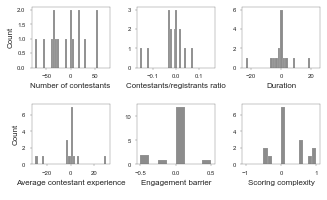

In [18]:
coarsened = ['num_contestants', 'contestant_registrant_ratio', 'duration', 
          'average_experience', 'engagement_barrier', 'scoring_complexity'] 
coarsened_titles = ['Number of contestants', 'Contestants/registrants ratio', 'Duration', 
                  'Average contestant experience', 'Engagement barrier', 'Scoring complexity']


fig = plt.figure(figsize = (4.5, 2.7))
gs = gridspec.GridSpec(2, 3, wspace=0.35, hspace=0.6, left=0.09, right=0.98, top=0.95, bottom=0.14)

num = 0
for i in coarsened:
    this_ax = fig.add_subplot(gs[num//3, num%3])
    abs_max = max(abs(min(matched_diff[i])), abs(max(matched_diff[i])))
    sns.distplot(matched_diff[i], kde=False, ax=this_ax, color='k', 
                 bins = len(matched_diff[i].unique())*2, hist_kws=dict(alpha=0.5),
                axlabel = coarsened_titles[num]+'\n')
    this_ax.set_xlim(-1.1*abs_max, 1.1*abs_max)
    if num%3==0:
        this_ax.set_ylabel('Count')
    num += 1
plt.savefig(f'{PLOTS_DIR}fig_s2.pdf', format='pdf')

In [19]:
# Assign strata to observations in challenge data

ch_df['stratum'] = np.nan
for stratum, challenges in matched.strata.items():
    round_ids = ch_df.iloc[challenges, :].index.tolist()
    ch_df.loc[ch_df.index.isin(round_ids), 'stratum'] = stratum
# Extract list of matched challenges
matched_ch_df = ch_df[ch_df['stratum'].notnull()]   

In [20]:
cat_vars = ['machine_learning', 'improve', 'target',
              'task_type', 'submission_type', 
              'provisional_testing', 'system_vs_provisional',
              'prize_nonmonetary', 'prize_threshold']

print('### DESCRIPTIVES FOR MATCHED DATA ###\n')
print(matched_ch_df[match_vars].describe())
for i in cat_vars:
    print(pd.crosstab(index=matched_ch_df[i], columns="count"))
print('Unique problems: ', len(matched_ch_df['problem_id'].unique()))

### DESCRIPTIVES FOR MATCHED DATA ###

       num_contestants  contestant_registrant_ratio    duration  \
count        52.000000                    52.000000   52.000000   
mean        122.230769                     0.767211  292.576923   
std          80.327178                     0.306699   96.458534   
min          10.000000                     0.144578    8.000000   
25%          62.500000                     0.476431  332.500000   
50%         109.500000                     0.975476  335.000000   
75%         172.000000                     1.000000  336.000000   
max         293.000000                     1.000000  355.000000   

       average_experience  engagement_barrier  scoring_complexity  prize_pool  \
count           52.000000           52.000000           52.000000        52.0   
mean            29.500638            1.894231            1.317308         0.0   
std             50.297394            0.285886            0.443127         0.0   
min              1.163347        

## 4. Find individuals within Strata

### 4.1. Normalize individual variables within challenge

In [32]:
ind_df = pd.read_csv(DATA_DIR + 'tcprofilesubset.csv')\
                  [['round_id', 'coder_id', 'handle', 'attended', \
                    'num_submissions', 'point_total', 'provisional_placed', \
                    'system_point_total', 'placed', 'rated_ind', 
                    'old_rating', 'new_rating', 'num_ratings']]

# Consider only participants who made at least 1 non-zero-point submission !!!
ind_df = ind_df[(ind_df['attended'] == 'Y') & (ind_df['num_submissions'] > 0)]
# Recode old_rating=0 as missing - these are data errors !!!
ind_df['old_rating'] = ind_df['old_rating'].replace(0, np.nan)

In [33]:
# Add challenge variables to individual data
ind_df = ind_df.merge(matched_ch_df[['round_id', 'duration', \
                                        'first_submission_time', 'last_submission_time']], \
                                        on='round_id', how='inner')

### Create new normalized individual-level variables

# Relative provisional score
ind_df['prov_score_norm'] = ind_df.groupby('round_id')['point_total']\
                                     .transform(lambda x: x / x.max())
# Relative final score
# Use provisional score if system score is missing !!!
ind_df.loc[ind_df['system_point_total'].isnull(), 'system_point_total'] = ind_df['point_total']
ind_df['fin_score_norm'] = ind_df.groupby('round_id')['system_point_total']\
                                 .transform(lambda x: x / x.max())
# Relative rating
ind_df['old_rating_norm'] = ind_df.groupby('round_id')['old_rating']\
                                  .transform(lambda x: x / x.max())
# Provisional rank percentile
ind_df['prov_rank_norm'] = ind_df.groupby('round_id')['point_total']\
                                 .rank(pct=True)
# Final rank percentile
ind_df['fin_rank_norm'] = ind_df.groupby('round_id')['system_point_total']\
                                 .rank(pct=True)
# Rating percentile
ind_df['old_rating_rank_norm'] = ind_df.groupby('round_id')['old_rating']\
                                       .rank(pct=True)
    
# Submission frquency counting registrants   
ind_df['submission_freq'] = (ind_df['num_submissions'] / ind_df['duration'])

# Predictability of performance
ind_df['predictability_prov'] = 1 - abs(ind_df['prov_rank_norm'] - ind_df['old_rating_rank_norm'])
ind_df['predictability_fin'] = 1 - abs(ind_df['fin_rank_norm'] - ind_df['old_rating_rank_norm'])
ind_df['predictability_norm_score'] = 1 - abs(ind_df['prov_score_norm'] - ind_df['old_rating_norm'])
ind_df['new_minus_old_rating'] = ind_df['new_rating'] - ind_df['old_rating']
ind_df['dev_from_predicted_prov'] = ind_df['prov_rank_norm'] - ind_df['old_rating_rank_norm']
ind_df['dev_from_predicted_fin'] = ind_df['fin_rank_norm'] - ind_df['old_rating_rank_norm']



# Inequality for individuals - deviation in score from maximum score
ind_df['prov_score_norm_distance'] = 1 - ind_df['prov_score_norm']
ind_df['fin_score_norm_distance'] = 1 - ind_df['fin_score_norm']

ind_df['num_nonmissing_prov'] = ind_df.groupby('round_id')['prov_score_norm'].transform('count')
ind_df['num_nonmissing_fin'] = ind_df.groupby('round_id')['fin_score_norm'].transform('count')
ind_df['num_nonmissing_numsubmissions'] = ind_df.groupby('round_id')['num_submissions'].transform('count')
ind_df['num_nonmissing_oldrating'] = ind_df.groupby('round_id')['old_rating'].transform('count')

ind_df['num_prev_ratings'] = ind_df['num_ratings'] - 1
ind_df.loc[ind_df['num_prev_ratings'] < 0, 'num_prev_ratings'] = 0
ind_df.loc[(ind_df['num_prev_ratings'] < 1) & (ind_df['old_rating'].notnull()), 'num_prev_ratings' ] = 1

### 4.2. Create new challenge-level variables from individual ones

In [36]:
def get_round_gini(df, var, numnonmiss):
    '''Gini coefficient, defined for 8+ participants'''
    return df[(df[var].notnull()) & (df[numnonmiss]>=8)]\
             .groupby('round_id')[var]\
             .apply( lambda x: gini(x.values) )  #.reset_index(name='coeff_var_prov')

def get_round_coeffvar(df, var, numnonmiss):
    '''Coefficient of variation, defined for 8+ participants'''
    return df[ind_df[var].notnull() & (df[numnonmiss]>=8)]\
             .groupby('round_id')[var]\
             .apply( lambda x: x.std() / x.mean() )

def get_round_mean(df, var):
    return df.groupby('round_id')[var].apply( lambda x: x.mean() )

def get_round_spearman(df, var):
    '''Spearman rank correlation between old_rating_rank_norm and var,
    defined for 8+ participants'''
    return df[(df['old_rating_rank_norm'].notnull()) & (df[var].notnull())]\
              .groupby('round_id')[['old_rating_rank_norm', var]]\
              .corr(method = 'spearman', min_periods = 8).iloc[0::2, -1]\
              .reset_index(level = 1, drop = True)

def read_diffs():
    '''Get measure of effort from diffs file.
    Effort = code lines of first submission + sum(insertions)
    '''
    vars1 = ['insertions', 'submission_lines', 'submission_number']
    df = pd.read_excel(DATA_DIR + 'diffs.xls', sheet_name='coder id and round id')
    for var in vars1:
        dfvar = pd.read_excel(DATA_DIR + 'diffs.xls', \
                              sheet_name=var, header=None, names=[var+str(i) for i in range(1, 163)])
        df = pd.concat([df, dfvar], axis=1)

    # Drop missing coders
    df = df[(df['round_id'] != 0) & (df['coder_id'] != 0)]
    # Drop first records of 4 coders who switched languages halfway through !!!
    df = df.drop_duplicates(subset = ['round_id', 'coder_id'])
    
    # Trnasform from wide to long
    df = pd.wide_to_long(df, stubnames=vars1, i=['round_id', 'coder_id'], j='temp')\
            .reset_index()
    # Drop missing submissions and temp column
    df = df[(df['submission_number'] > 0)]
    df = df.drop(columns=['temp'])
    
    # Recode diffs for submission_number==1 as missing
    df.loc[df['submission_number']==1, 'insertions'] = np.nan
    
    sum_insertions = df.groupby(['round_id', 'coder_id'])['insertions']\
                     .apply( lambda x: x.sum() ).reset_index()
    
    # If first submission is missing, get the number of lines of the next available
    df.sort_values(by=['round_id', 'coder_id', 'submission_number'], inplace=True)
    firsts = df.groupby(['round_id', 'coder_id']).first().reset_index()[['round_id', 'coder_id', 'submission_lines']]
    
    # Get the number of lines of last submission
    lasts = df.groupby(['round_id', 'coder_id']).last().reset_index()[['round_id', 'coder_id', 'submission_lines']]
    lasts.columns = ['round_id', 'coder_id', 'last_submission_lines']
    
    df = firsts.merge(sum_insertions, on=['round_id', 'coder_id'], how='left')
    df['sum_code_lines'] = df['submission_lines'] + df['insertions']
    df = df[['round_id', 'coder_id', 'submission_lines', 'insertions', 'sum_code_lines']]
    df.columns = ['round_id', 'coder_id', 'first_submission_lines', 'sum_insertions', 'sum_code_lines']
    df = df.merge(lasts, on=['round_id', 'coder_id'], how='left')
    
    return df
     

# Get complexities
comp_df = pd.read_csv(DATA_DIR + 'complexities.csv')\
                  [['round_id', 'coder_id', 'Complexity_First', 'Complexity_Last']]
comp_df.columns = ['round_id', 'coder_id', 'first_complexity', 'last_complexity']
comp_df['num_nonmissing_firstcomp'] = comp_df.groupby('round_id')['first_complexity'].transform('count')
comp_df['num_nonmissing_lastcomp'] = comp_df.groupby('round_id')['last_complexity'].transform('count')

# Get diffs
diff_df = read_diffs()
diff_df['num_nonmissing_sumcodelines'] = diff_df.groupby('round_id')['sum_code_lines'].transform('count')

# Add complexities and diffs to individual data
ind_df = ind_df.merge(comp_df, on=['round_id', 'coder_id'], how='left')
ind_df = ind_df.merge(diff_df, on=['round_id', 'coder_id'], how='left')


print('Unique individuals:', len(ind_df['coder_id'].unique()))

print(ind_df\
      [['num_submissions', 'num_ratings', 'num_prev_ratings', 'old_rating_rank_norm', \
        'predictability_prov', 'prov_score_norm_distance', 'last_complexity', 'sum_code_lines']].describe())
 

Unique individuals: 2774
       num_submissions  num_ratings  num_prev_ratings  old_rating_rank_norm  \
count      5916.000000  5916.000000       5916.000000           4158.000000   
mean          7.863590     9.118492          8.203854              0.505892   
std           9.364118    13.230564         13.175454              0.288762   
min           1.000000     0.000000          0.000000              0.003937   
25%           2.000000     1.000000          0.000000              0.255443   
50%           5.000000     4.000000          3.000000              0.505814   
75%          10.000000    12.000000         11.000000              0.755148   
max         162.000000   126.000000        125.000000              1.000000   

       predictability_prov  prov_score_norm_distance  last_complexity  \
count          4158.000000               5916.000000      5577.000000   
mean              0.813346                  0.430351       117.179666   
std               0.162194                  

In [37]:
### EFFORT

# Mean frequency of submissions 
mean_submit_num = get_round_mean(ind_df, 'num_submissions')
# Median frequency of submissions 
median_submit_num = ind_df\
                    .groupby('round_id')['num_submissions']\
                    .apply( lambda x: x.median() )
# Coefficient of variation for number of submissions
coeff_var_num_submissions = get_round_coeffvar(ind_df, 'num_submissions', 'num_nonmissing_numsubmissions')
# Coefficient of variation for total code lines
coeff_var_sum_code_lines = get_round_coeffvar(ind_df, 'sum_code_lines', 'num_nonmissing_sumcodelines')
# Gini coefficient for number of submissions
gini_num_submissions = get_round_gini(ind_df, 'num_submissions', 'num_nonmissing_numsubmissions')
# Gini coefficient for total code lines
gini_sum_code_lines = get_round_gini(ind_df, 'sum_code_lines', 'num_nonmissing_sumcodelines')
  
        
### INEQUALITY - DEFINED FOR 8+ participants

# Coefficient of variation for provisional scores
coeff_var_prov = get_round_coeffvar(ind_df, 'prov_score_norm', 'num_nonmissing_prov')
# Coefficient of variation for final scores
coeff_var_fin = get_round_coeffvar(ind_df, 'fin_score_norm', 'num_nonmissing_fin')
# Coefficient of variation for first complexities
coeff_var_firstcomp = get_round_coeffvar(ind_df, 'first_complexity', 'num_nonmissing_firstcomp')
# Coefficient of variation for last complexities
coeff_var_lastcomp = get_round_coeffvar(ind_df, 'last_complexity', 'num_nonmissing_lastcomp')

# Gini coefficient for provisional scores
gini_prov = get_round_gini(ind_df, 'prov_score_norm', 'num_nonmissing_prov')
# Gini coefficient for final scores
gini_fin = get_round_gini(ind_df, 'fin_score_norm', 'num_nonmissing_fin') 
# Gini coefficient for ffirst complexities
gini_firstcomp = get_round_gini(ind_df, 'first_complexity', 'num_nonmissing_firstcomp') 
# Gini coefficient for last complexities
gini_lastcomp = get_round_gini(ind_df, 'last_complexity', 'num_nonmissing_lastcomp') 

### PREDICTABILITY - DEFINED FOR 8+ participants

# Spearman rank correlation between old_rating_rank_norm and prov_rank_norm
corr_old_prov_rank = get_round_spearman(ind_df, 'prov_rank_norm')         
# Spearman rank correlation betwen old_rating_rank_norm and fin_rank_norm
corr_old_fin_rank = get_round_spearman(ind_df, 'fin_rank_norm')             
# Spearman rank correlation betwen old_rating and new_rating
corr_old_new_rating = get_round_spearman(ind_df, 'new_rating') 
# Spearman rank correlation between old_rating_norm and prov_score_norm
corr_old_prov_score = get_round_spearman(ind_df, 'prov_score_norm') 


# Mean new_rating for newcomers
mean_rating_newcomers = ind_df[(ind_df['num_ratings'] < 2) \
                                   & (ind_df['new_rating'].notnull())]\
                                   .groupby('round_id')['new_rating']\
                                   .apply( lambda x: x.mean() )
# Median new_rating for newcomers
median_rating_newcomers = ind_df[(ind_df['num_ratings'] < 2) \
                                   & (ind_df['new_rating'].notnull())]\
                                   .groupby('round_id')['new_rating']\
                                   .apply( lambda x: x.median() )

### PARTICIPANT PROFILES
ind_df['newcomer'] = (ind_df['num_ratings'] < 2)
prop_newcomers = ind_df.groupby('round_id')['newcomer'].apply( lambda x: x.sum() / x.count() )
mean_old_rating = ind_df[ind_df['old_rating'].notnull()]\
                  .groupby('round_id')['old_rating'].apply( lambda x: x.mean() )
median_old_rating = ind_df[ind_df['old_rating'].notnull()]\
                  .groupby('round_id')['old_rating'].apply( lambda x: x.median() )
gini_old_rating = get_round_gini(ind_df, 'old_rating', 'num_nonmissing_oldrating') 
coeff_var_old_rating = get_round_coeffvar(ind_df, 'old_rating', 'num_nonmissing_oldrating') 


new = pd.concat([mean_submit_num, median_submit_num, 
                 coeff_var_num_submissions, gini_num_submissions,
                 coeff_var_sum_code_lines, gini_sum_code_lines,
                 coeff_var_prov, coeff_var_fin, coeff_var_firstcomp, coeff_var_lastcomp, 
                 gini_prov, gini_fin, gini_firstcomp, gini_lastcomp, 
                 corr_old_prov_rank, corr_old_fin_rank, 
                 corr_old_new_rating, corr_old_prov_score, 
                 mean_rating_newcomers, median_rating_newcomers,
                 prop_newcomers,
                 mean_old_rating, median_old_rating,
                gini_old_rating, coeff_var_old_rating], axis=1)
new.columns = ['mean_submit_num', 'median_submit_num', 
               'coeff_var_num_submissions', 'gini_num_submissions',
               'coeff_var_sum_code_lines', 'gini_sum_code_lines',
               'coeff_var_prov', 'coeff_var_fin', 'coeff_var_firstcomp', 'coeff_var_lastcomp', 
               'gini_prov', 'gini_fin', 'gini_firstcomp', 'gini_lastcomp', 
               'corr_old_prov_rank', 'corr_old_fin_rank', 
               'corr_old_new_rating', 'corr_old_prov_score', 
               'mean_rating_newcomers', 'median_rating_newcomers',
               'prop_newcomers',
               'mean_old_rating', 'median_old_rating',
               'gini_old_rating', 'coeff_var_old_rating']
new.reset_index(inplace=True)
#print(new.head(n=5))


### 4.3. Check for challenge outliers in terms of individual performance

<AxesSubplot:xlabel='corr_old_prov_rank'>

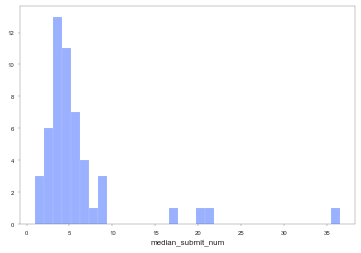

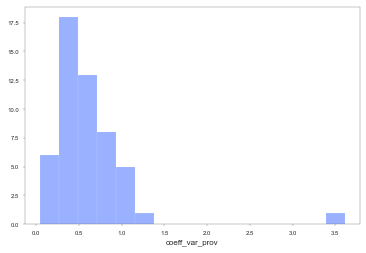

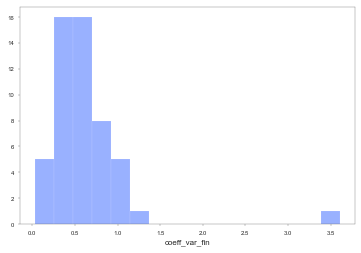

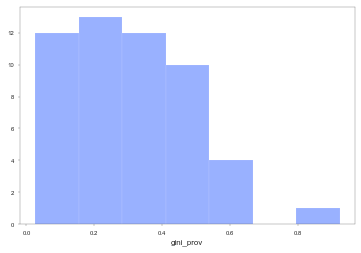

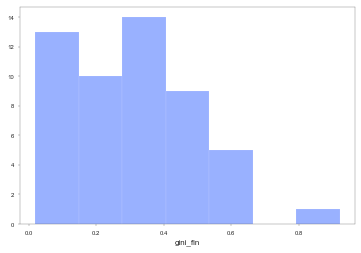

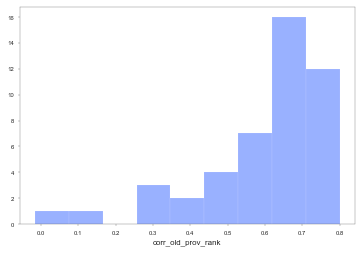

In [38]:
# Merge challenge-level variables to matched challenge data and export
matched_ch_df = matched_ch_df.merge(new, on='round_id', how='left')\
                                .sort_values(by = ['stratum', 'scoring_type'])
# Save matches to csv
matched_ch_df.to_csv('challenges_matched.csv', index = False)



plt.figure()
sns.distplot(matched_ch_df['median_submit_num'][matched_ch_df['median_submit_num'].notnull()], kde=False)
plt.figure()
sns.distplot(matched_ch_df['coeff_var_prov'][matched_ch_df['coeff_var_prov'].notnull()], kde=False)
plt.figure()
sns.distplot(matched_ch_df['coeff_var_fin'][matched_ch_df['coeff_var_fin'].notnull()], kde=False)
plt.figure()
sns.distplot(matched_ch_df['gini_prov'][matched_ch_df['gini_prov'].notnull()], kde=False)
plt.figure()
sns.distplot(matched_ch_df['gini_fin'][matched_ch_df['gini_fin'].notnull()], kde=False)
plt.figure()
sns.distplot(matched_ch_df['corr_old_prov_rank'][matched_ch_df['corr_old_prov_rank'].notnull()], kde=False)




### 4.4. Keep only individual-stratum observations that have at least 1 relative and 1 absolute observations in a stratum

In [39]:
def get_individual_data_for_matched_challenges(df_in, df_ch, fname):
    '''All individuals in matched challenges'''
    challenge_vars = ['round_id', "num_contestants", 'contestant_registrant_ratio', 
                  "average_experience", "engagement_barrier", 'scoring_complexity', 
                  "provisional_testing", "task_type",
                  'target', 'improve', 'scoring_type', 'stratum']
    
    df_in_matched_ch = df_in.merge(df_ch[challenge_vars], on='round_id', how='inner')
    # Save data to file
    df_in_matched_ch = df_in_matched_ch\
                    .sort_values(by = ['stratum', 'scoring_type', 'coder_id'])\
                    .reset_index(drop = True)
    df_in_matched_ch.to_csv(fname, index = False)
    return df_in_matched_ch
    

def get_matched_individuals(df_in, df_ch, fname):
    '''Rated individuals who have participated in at least one absolutely 
    and one relatively scored challenge in a stratum.'''
    challenge_vars = ['round_id', "num_contestants", 'contestant_registrant_ratio', 
                  "average_experience", "engagement_barrier", 'scoring_complexity', 
                  "provisional_testing", "task_type",
                  'target', 'improve', 'scoring_type', 'stratum']
    
    df_in = df_in[df_in['old_rating_rank_norm'].notnull()]
    matched_df_in = df_in.merge(df_ch[challenge_vars], on='round_id', how='inner')
    matched_df_in = matched_df_in.groupby(['stratum', 'coder_id'])\
                                 .filter(lambda x: len(x['scoring_type'].unique()) > 1)
    # Save data to file
    matched_df_in = matched_df_in\
                    .sort_values(by = ['stratum', 'coder_id', 'scoring_type'])\
                    .reset_index(drop = True)
    matched_df_in.to_csv(fname, index = False)
    return matched_df_in


individuals_in_matched_data = get_individual_data_for_matched_challenges(ind_df, \
                                        matched_ch_df, 'individuals_in_matched_challenges.csv')
matched_ind_df = get_matched_individuals(ind_df, \
                                        matched_ch_df, 'individuals_matched.csv')


## 5. Challenge-level results

In [40]:
print('Number of observations of matched individuals:', len(matched_ind_df['coder_id']))
print('Number of unique matched individuals:', len(matched_ind_df['coder_id'].unique()))
print('Number of rounds for matched individuals:', len(matched_ind_df['round_id'].unique()))
print('Number of strata for matched individuals:', len(matched_ind_df['stratum'].unique()))
print('Number of submissions for matched individuals:', sum(matched_ind_df['num_submissions'].values))

print(matched_ind_df\
      [['num_submissions', 'num_ratings', 'num_prev_ratings', 'old_rating_rank_norm', \
        'predictability_prov', 'prov_score_norm_distance', 'last_complexity', 'sum_code_lines']].describe())

Number of observations of matched individuals: 1239
Number of unique matched individuals: 319
Number of rounds for matched individuals: 42
Number of strata for matched individuals: 12
Number of submissions for matched individuals: 12914
       num_submissions  num_ratings  num_prev_ratings  old_rating_rank_norm  \
count      1239.000000  1239.000000       1239.000000           1239.000000   
mean         10.422922    20.718321         19.718321              0.565352   
std          11.312437    18.344546         18.344546              0.289906   
min           1.000000     2.000000          1.000000              0.003937   
25%           3.000000     7.000000          6.000000              0.329774   
50%           7.000000    16.000000         15.000000              0.594488   
75%          13.000000    28.000000         27.000000              0.820534   
max         147.000000   126.000000        125.000000              1.000000   

       predictability_prov  prov_score_norm_distanc

<ipython-input-42-7b17bb51260c>:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{PLOTS_DIR}fig_1.pdf', type='pdf')
<ipython-input-42-7b17bb51260c>:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{PLOTS_DIR}newcomers_rating_mean_by_challenge.pdf', type='pdf')
<ipython-input-42-7b17bb51260c>:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{PLOTS_DIR}fig_s3.pdf', type='pdf')


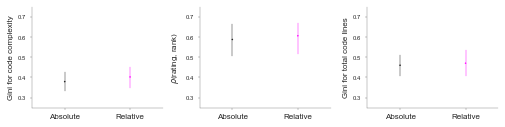

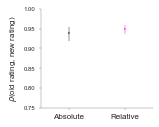

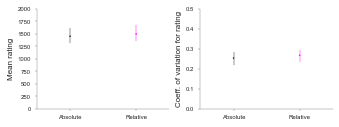

In [42]:
def plot_mean_stratum_val(df, ax, y, yname, ylim):
    mean_df = df.groupby(['stratum', 'scoring_type'])[y].mean().reset_index()
    # Keep only strata that have both values
    mean_df = mean_df.groupby('stratum').filter(lambda x: x[y].count() == 2)  
    sns.pointplot(x='scoring_type', y=y, data=mean_df, ax = ax, palette=['k', 'magenta'])
    ax.set_xlabel('')
    ax.set_ylabel(yname)
    sns.despine()
    ax.set_ylim(ylim[0], ylim[1])
    #ax.grid(axis='y')

mpl.rcParams['xtick.labelsize'] = 8  

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (7, 1.75))
plot_mean_stratum_val(matched_ch_df, ax[0], 'gini_lastcomp', "Gini for code complexity", (0.25, 0.75))
plot_mean_stratum_val(matched_ch_df, ax[1], 'corr_old_prov_rank', r"$\rho$(rating, rank)", (0.25, 0.75))
plot_mean_stratum_val(matched_ch_df, ax[2], 'gini_sum_code_lines', "Gini for total code lines", (0.25, 0.75)) 
plt.tight_layout()
plt.savefig(f'{PLOTS_DIR}fig_1.pdf', type='pdf')

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (2.2, 1.75))
plot_mean_stratum_val(matched_ch_df, ax, 'corr_old_new_rating', r"$\rho$(old rating, new rating)", (0.75, 1))
plt.tight_layout()
plt.savefig(f'{PLOTS_DIR}newcomers_rating_mean_by_challenge.pdf', type='pdf')

mpl.rcParams['xtick.labelsize'] = 6

#print(mannwhitneyu(matched_ch_df[matched_ch_df['scoring_type']=='Absolute']['corr_old_new_rating'],\
#              matched_ch_df[matched_ch_df['scoring_type']=='Relative']['corr_old_new_rating']))

matched_ch_df.columns

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (4.7, 1.75))
plot_mean_stratum_val(matched_ch_df, ax[0], 'mean_old_rating', "Mean rating", (0, 2000))
plot_mean_stratum_val(matched_ch_df, ax[1], 'coeff_var_old_rating', "Coeff. of variation for rating", (0, 0.5)) 
plt.tight_layout()
plt.savefig(f'{PLOTS_DIR}fig_s3.pdf', type='pdf')


## 6.1. Individual-level results – Relative rating

(954, 5)
(954, 5)
(954, 5)
(954, 5)
(954, 5)
(954, 5)
(954, 5)


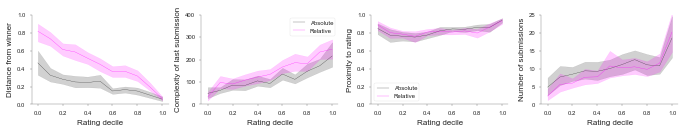

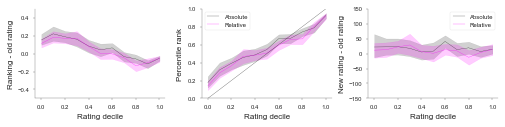

In [43]:
def plot_indiv_mean_stratum_val(df, ax, y, yname, ylim):
    mean_df = df.groupby(['stratum', 'coder_id', 'scoring_type'])[y].mean().reset_index()
    #sns.pointplot(x='scoring_type', y=y, data=mean_df, ax = ax, markers="", join=True, ci=None, color='0.5')
    sns.pointplot(x='scoring_type', y=y, data=mean_df, ax = ax, palette=['k', 'magenta'])
    ax.set_xlabel('')
    ax.set_ylabel(yname, fontsize=8)
    sns.despine()
    ax.set_ylim(ylim[0],ylim[1])
    #ax.grid('on')
    
def plot_indiv_mean_stratum_val_by_rating(df, ax, y, yname, ylim, legend = False):
    mean_df = df.groupby(['stratum', 'coder_id', 'scoring_type'])[['old_rating_rank_norm', y]].mean().reset_index()
    print(mean_df.shape)
    mean_df['old_rating_rank_decile'] = mean_df['old_rating_rank_norm'].round(1)
    sns.lineplot(x='old_rating_rank_decile', y=y, hue='scoring_type', data=mean_df, ax = ax, palette=['k', 'magenta'])
    ax.set_xlabel('Rating decile', fontsize=8)
    ax.set_ylabel(yname, fontsize=8)
    sns.despine()
    ax.set_ylim(ylim[0],ylim[1])
    if legend==False:
        ax.legend().set_visible(False)
    else:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles[1:], labels=labels[1:])
    #ax.grid('on')

#fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (7, 1.75))
#plot_indiv_mean_stratum_val(matched_ind_df, ax[0], 'prov_score_norm_distance', "Distance from winner", (0, 1))
#plot_indiv_mean_stratum_val(matched_ind_df, ax[1], 'predictability_prov', "Proximity to rating", (0, 1))
#plot_indiv_mean_stratum_val(matched_ind_df, ax[2], 'num_submissions', "Number of submissions", (0, 11)) 
#plt.tight_layout()



# Plot predictability by 'old_rating_rank_norm' for absolute and relative
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (9.5, 1.75))
plot_indiv_mean_stratum_val_by_rating(matched_ind_df, ax[0], 'prov_score_norm_distance', "Distance from winner", (0, 1))
plot_indiv_mean_stratum_val_by_rating(matched_ind_df, ax[1], 'last_complexity', "Complexity of last submission", (0, 400), legend=True)
plot_indiv_mean_stratum_val_by_rating(matched_ind_df, ax[2], 'predictability_prov', "Proximity to rating", (0, 1), legend=True)
plot_indiv_mean_stratum_val_by_rating(matched_ind_df, ax[3], 'num_submissions', "Number of submissions", (0, 25))
plt.tight_layout()



fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (7, 1.75))
plot_indiv_mean_stratum_val_by_rating(matched_ind_df, ax[0], 'dev_from_predicted_prov', "Ranking - old rating", (-0.5, 0.5))
plot_indiv_mean_stratum_val_by_rating(matched_ind_df, ax[1], 'prov_rank_norm', "Percentile rank", (0, 1), legend=True)
ax[1].plot([0,1], [0,1], 'k')
plot_indiv_mean_stratum_val_by_rating(matched_ind_df, ax[2], 'new_minus_old_rating', "New rating - old rating", (-150, 150), legend=True)
plt.tight_layout()


## 6.2. Individual-level results – Absolute rating

(954, 5)
(954, 5)
(954, 5)
(954, 5)


<ipython-input-45-d38025ba07e7>:41: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{PLOTS_DIR}fig_2_abs.pdf', type='pdf')


(954, 5)
(954, 5)


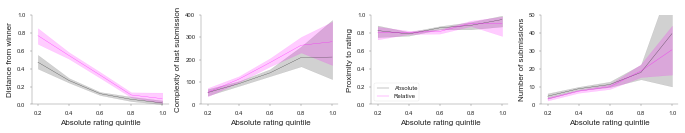

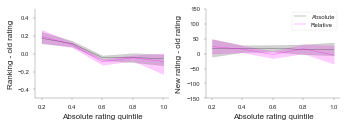

In [45]:
def plot_indiv_mean_stratum_val_abs(df, ax, y, yname, ylim):
    mean_df = df.groupby(['stratum', 'coder_id', 'scoring_type'])[y].mean().reset_index()
    #sns.pointplot(x='scoring_type', y=y, data=mean_df, ax = ax, markers="", join=True, ci=None, color='0.5')
    sns.pointplot(x='scoring_type', y=y, data=mean_df, ax = ax, palette=['k', 'magenta'])
    ax.set_xlabel('')
    ax.set_ylabel(yname, fontsize=8)
    sns.despine()
    ax.set_ylim(ylim[0],ylim[1])
    #ax.grid('on')
    
def plot_indiv_mean_stratum_val_by_rating_abs(df, ax, y, yname, ylim, legend = False):
    mean_df = df.groupby(['stratum', 'coder_id', 'scoring_type'])[['old_rating', y]].mean().reset_index()
    print(mean_df.shape)
    mean_df['old_rating_decile'] = (0.5 * mean_df['old_rating'] / max(mean_df['old_rating'].values)).round(1) * 2
    sns.lineplot(x='old_rating_decile', y=y, hue='scoring_type', data=mean_df, ax = ax, palette=['k', 'magenta'])
    ax.set_xlabel('Absolute rating quintile', fontsize=8)
    ax.set_ylabel(yname, fontsize=8)
    sns.despine()
    ax.set_ylim(ylim[0],ylim[1])
    if legend==False:
        ax.legend().set_visible(False)
    else:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles[1:], labels=labels[1:])
    #ax.grid('on')

#fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (7, 2))
#plot_indiv_mean_stratum_val(matched_ind_df, ax[0], 'prov_score_norm_distance', "Distance from winner", (0, 1))
#plot_indiv_mean_stratum_val(matched_ind_df, ax[1], 'predictability_prov', "Proximity to rating", (0, 1))
#plot_indiv_mean_stratum_val(matched_ind_df, ax[2], 'num_submissions', "Number of submissions", (0, 11)) 
#plt.tight_layout()


# Plot predictability by 'old_rating_rank_norm' for absolute and relative
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (9.5, 1.75))
plot_indiv_mean_stratum_val_by_rating_abs(matched_ind_df, ax[0], 'prov_score_norm_distance', "Distance from winner", (0, 1))
plot_indiv_mean_stratum_val_by_rating_abs(matched_ind_df, ax[1], 'last_complexity', "Complexity of last submission", (0, 400))
plot_indiv_mean_stratum_val_by_rating_abs(matched_ind_df, ax[2], 'predictability_prov', "Proximity to rating", (0, 1), legend=True)
plot_indiv_mean_stratum_val_by_rating_abs(matched_ind_df, ax[3], 'num_submissions', "Number of submissions", (0, 50))
plt.tight_layout()
plt.savefig(f'{PLOTS_DIR}fig_2_abs.pdf', type='pdf')


fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (4.8, 1.75))
plot_indiv_mean_stratum_val_by_rating_abs(matched_ind_df, ax[0], 'dev_from_predicted_prov', "Ranking - old rating", (-0.5, 0.5))
plot_indiv_mean_stratum_val_by_rating_abs(matched_ind_df, ax[1], 'new_minus_old_rating', "New rating - old rating", (-150, 150), legend=True)
plt.tight_layout()


In [46]:
print('Unique individuals:', len(matched_ind_df['coder_id'].unique()))

print(matched_ind_df\
      [['num_submissions', 'num_ratings', 'old_rating_rank_norm', \
        'predictability_prov', 'prov_score_norm_distance']].describe())

Unique individuals: 319
       num_submissions  num_ratings  old_rating_rank_norm  \
count      1239.000000  1239.000000           1239.000000   
mean         10.422922    20.718321              0.565352   
std          11.312437    18.344546              0.289906   
min           1.000000     2.000000              0.003937   
25%           3.000000     7.000000              0.329774   
50%           7.000000    16.000000              0.594488   
75%          13.000000    28.000000              0.820534   
max         147.000000   126.000000              1.000000   

       predictability_prov  prov_score_norm_distance  
count          1239.000000               1239.000000  
mean              0.830196                  0.332587  
std               0.151150                  0.298719  
min               0.181465                  0.000000  
25%               0.760349                  0.082164  
50%               0.867449                  0.248470  
75%               0.946288               

## 7. Export file with matched individuals or newcomers in matched challenges

In [48]:
# Import first-timers data (excluding those who are unrated but have 
# particpated in a challenge before) and match with individual-level data
newcom_df = pd.read_csv(DATA_DIR + 'newcomers.csv')[['round_id', 'coder_id', 'ReturnTime']]
newcom_df['returned'] = 0
newcom_df.loc[newcom_df['ReturnTime'].notnull(), 'returned'] = 1
newcom_df = newcom_df[['round_id', 'coder_id', 'returned']] \
                 .merge(individuals_in_matched_data, on=['round_id', 'coder_id'], how='inner')

# Keep only if both control and treatment in stratum
newcom_df = newcom_df[newcom_df.groupby('stratum')['scoring_type']\
                               .transform(lambda x: len(x.unique())) > 1]
newcom_df['newcomer'] = 1

matched_ind_df['newcomer'] = 0
newdf = pd.concat([matched_ind_df[['stratum', 
                                   'round_id', 
                                   'coder_id', 
                                   'newcomer']], newcom_df[['stratum', 
                                                            'round_id', 
                                                            'coder_id', 
                                                            'newcomer']]], axis=0, ignore_index=True)
newdf.to_csv(f'{DATA_DIR}/out/matched_individuals_plus_newcomers.csv', index = False)

FileNotFoundError: [Errno 2] No such file or directory: '../data//out/matched_individuals_plus_newcomers.csv'